In [22]:
import joblib
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [25]:
# Load and prepare the data
file_path = "../data/df_restaurants_model.csv"
df_restaurants_model = pd.read_csv(file_path)

# Convert boolean columns to integers
df_restaurants_model = df_restaurants_model.astype({col: 'int' for col in df_restaurants_model.select_dtypes(include=['bool']).columns})

df_restaurants_model.head()

,stars,delivery,alcohol,bike_parking,credit_card,appointment_only,caters,coat_check,dogs,drive_thru,...,food_type_one_Italian,food_type_one_Japanese,food_type_one_Mexican,food_type_one_Sandwiches,food_type_one_Seafood,food_type_one_Steakhouses,food_type_one_Thai,food_type_one_Vietnamese,food_type_one_None,state_encoded
0,4.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,5.0
1,2.0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.0
2,3.0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,11.0
3,1.5,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.0
4,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.0


In [34]:
# Check which columns have missing values
missing_values_summary = df_restaurants_model.isnull().sum()
print("Missing values per column before imputation:")
print(missing_values_summary)

Missing values per column before imputation:
stars                             0
delivery                          0
alcohol                           0
bike_parking                      0
credit_card                       0
appointment_only                  0
caters                            0
coat_check                        0
dogs                              0
drive_thru                        0
good_for_kids                     0
good_for_groups                   0
happy_hour                        0
tv                                0
outdoor_seating                   0
price_range                       0
reservations                      0
table_service                     0
take_out                          0
wheelchair                        0
wifi                              0
hours_per_week                 7275
open_on_weekend                   0
food_type_one_American            0
food_type_one_Barbeque            0
food_type_one_Burgers             0
food_type_one_Cafes

In [36]:
# Impute missing values for 'hours_weekend'
imputer = SimpleImputer(strategy='mean')

# Apply imputation to the entire dataset (or select specific columns if needed)
df_restaurants_model_imputed = df_restaurants_model.copy()
df_restaurants_model_imputed.loc[:, :] = imputer.fit_transform(df_restaurants_model_imputed)

/var/folders/pp/83wrh0zd09gbbvzv0d9wrc7h0000gn/T/ipykernel_37967/2785109382.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_restaurants_model_imputed.loc[:, :] = imputer.fit_transform(df_restaurants_model_imputed)


In [37]:
# Verify that missing values have been imputed
missing_values_summary_after = df_restaurants_model_imputed.isnull().sum()
print("\nMissing values per column after imputation:")
print(missing_values_summary_after)


Missing values per column after imputation:
stars                          0
delivery                       0
alcohol                        0
bike_parking                   0
credit_card                    0
appointment_only               0
caters                         0
coat_check                     0
dogs                           0
drive_thru                     0
good_for_kids                  0
good_for_groups                0
happy_hour                     0
tv                             0
outdoor_seating                0
price_range                    0
reservations                   0
table_service                  0
take_out                       0
wheelchair                     0
wifi                           0
hours_per_week                 0
open_on_weekend                0
food_type_one_American         0
food_type_one_Barbeque         0
food_type_one_Burgers          0
food_type_one_Cafes            0
food_type_one_Cajun/Creole     0
food_type_one_Chicken Wings    

In [38]:
# Proceed with the feature engineering and model preparation after imputation
df_restaurants_model_imputed['delivery_drive_thru'] = df_restaurants_model_imputed['delivery'] * df_restaurants_model_imputed['drive_thru']
X = df_restaurants_model_imputed.drop(columns=['stars'])

X.head()

In [45]:
# Add the constant term for VIF calculation
X_with_interaction = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_interaction.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_interaction.values, i) for i in range(X_with_interaction.shape[1])]

# Display VIF values
print(vif_data)

# Drop 'delivery' and 'drive_thru' if VIF is too high, typically above 5 or 10
columns_to_drop_due_to_vif = vif_data[vif_data['VIF'] > 5]['Feature'].tolist()

# If we need to drop based on VIF, we would update X_reduced
X_reduced_vif_checked = sm.add_constant(X.drop(columns=columns_to_drop_due_to_vif))

print(f"Columns dropped due to high VIF: {columns_to_drop_due_to_vif}")
print(f"Remaining columns after VIF check: {X_reduced_vif_checked.columns}")

/Users/vguetermann/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/vguetermann/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                        Feature       VIF
0                         const  0.000000
1                      delivery  1.272743
2                       alcohol  1.913791
3                  bike_parking  1.271215
4                   credit_card  1.282933
5              appointment_only  1.008919
6                        caters  1.328522
7                    coat_check  1.038435
8                          dogs  1.166343
9                    drive_thru  9.343232
10                good_for_kids  1.604703
11              good_for_groups  1.667909
12                   happy_hour  1.499316
13                           tv  1.291618
14              outdoor_seating  1.278458
15                  price_range  1.582040
16                 reservations  1.507790
17                table_service  1.522165
18                     take_out  1.313397
19                   wheelchair  1.534958
20                         wifi  1.331905
21               hours_per_week  1.464788
22              open_on_weekend  1

In [50]:
# Check the correlation of columns to be potentially dropped with the target variable
columns_to_drop = ['delivery', 'alcohol', 'bike_parking', 'credit_card',
       'appointment_only', 'caters', 'coat_check', 'dogs', 'good_for_kids',
       'good_for_groups', 'happy_hour', 'tv', 'outdoor_seating', 'price_range',
       'reservations', 'table_service', 'take_out', 'wheelchair', 'wifi',
       'hours_per_week', 'open_on_weekend', 'state_encoded']
X_reduced = sm.add_constant(X.drop(columns=[col for col in columns_to_drop if col in X.columns]))

# Calculate the correlation matrix
correlation_matrix = df_restaurants_model_imputed[columns_to_drop + ['stars']].corr()

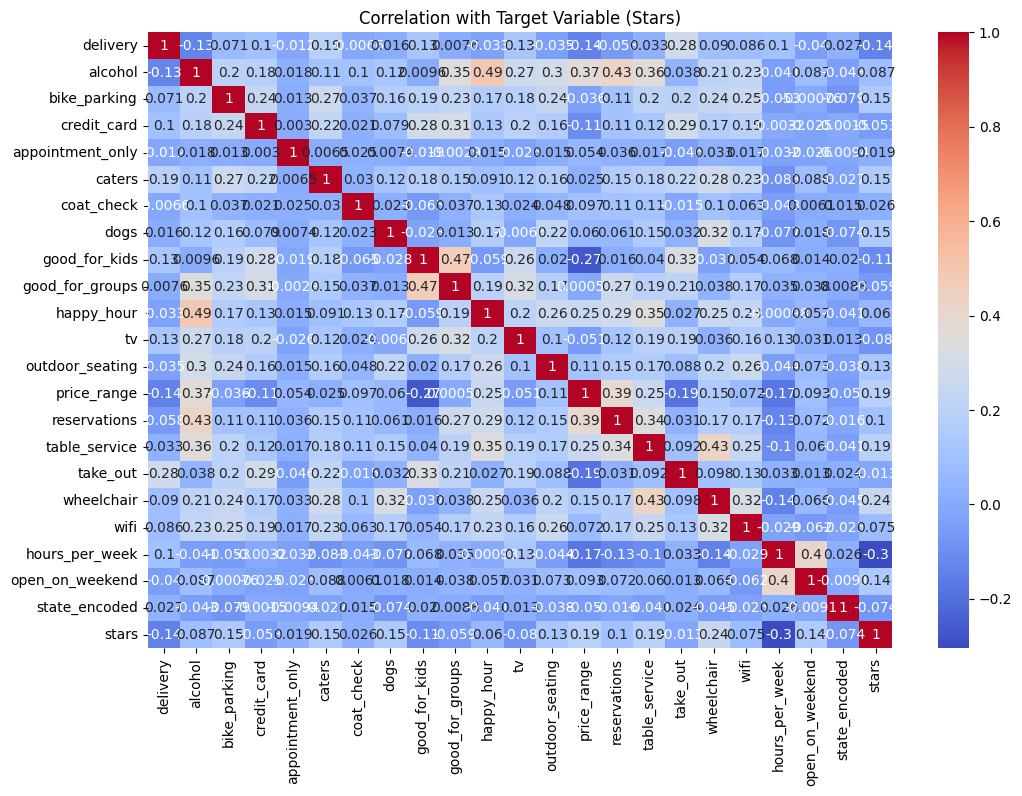

In [51]:
# Visualize the correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation with Target Variable (Stars)')
plt.show()

In [52]:
# Define a threshold for low correlation
low_correlation_threshold = 0.1

# Calculate the correlation of all features with the target variable 'stars'
correlation_with_stars = df_restaurants_model_imputed.corr()['stars'].drop('stars')

# Identify features with low correlation with 'stars'
low_correlation_features = correlation_with_stars[abs(correlation_with_stars) < low_correlation_threshold].index.tolist()

# Output the list of features with low correlation
print(f"Features with very low correlation (absolute value < {low_correlation_threshold}) with 'stars':")
print(low_correlation_features)

Features with very low correlation (absolute value < 0.1) with 'stars':
['alcohol', 'credit_card', 'appointment_only', 'coat_check', 'good_for_groups', 'happy_hour', 'tv', 'take_out', 'wifi', 'food_type_one_American', 'food_type_one_Barbeque', 'food_type_one_Cajun/Creole', 'food_type_one_Chinese', 'food_type_one_Delis', 'food_type_one_Diners', 'food_type_one_Greek', 'food_type_one_Indian', 'food_type_one_Italian', 'food_type_one_Japanese', 'food_type_one_Mexican', 'food_type_one_Sandwiches', 'food_type_one_Seafood', 'food_type_one_Steakhouses', 'food_type_one_Thai', 'food_type_one_Vietnamese', 'food_type_one_None', 'state_encoded']


In [58]:
# Drop columns with features with low correlation
columns_to_drop = ['alcohol', 'credit_card', 'appointment_only', 'coat_check', 'good_for_groups', 'happy_hour', 'tv', 'take_out', 'wifi']

In [60]:
X_reduced = sm.add_constant(X.drop(columns=[col for col in columns_to_drop if col in X.columns]))
y = df_restaurants_model_imputed['stars']
# Output the final dataset for verification
print(f"Final feature set after imputation and feature engineering: {X_reduced.columns}")

X_reduced.head()

Final feature set after imputation and feature engineering: Index(['const', 'delivery', 'bike_parking', 'caters', 'dogs', 'drive_thru',
       'good_for_kids', 'outdoor_seating', 'price_range', 'reservations',
       'table_service', 'wheelchair', 'hours_per_week', 'open_on_weekend',
       'food_type_one_American', 'food_type_one_Barbeque',
       'food_type_one_Burgers', 'food_type_one_Cafes',
       'food_type_one_Cajun/Creole', 'food_type_one_Chicken Wings',
       'food_type_one_Chinese', 'food_type_one_Delis', 'food_type_one_Diners',
       'food_type_one_Greek', 'food_type_one_Indian', 'food_type_one_Italian',
       'food_type_one_Japanese', 'food_type_one_Mexican',
       'food_type_one_Sandwiches', 'food_type_one_Seafood',
       'food_type_one_Steakhouses', 'food_type_one_Thai',
       'food_type_one_Vietnamese', 'food_type_one_None', 'state_encoded',
       'delivery_drive_thru'],
      dtype='object')


,const,delivery,bike_parking,caters,dogs,drive_thru,good_for_kids,outdoor_seating,price_range,reservations,...,food_type_one_Japanese,food_type_one_Mexican,food_type_one_Sandwiches,food_type_one_Seafood,food_type_one_Steakhouses,food_type_one_Thai,food_type_one_Vietnamese,food_type_one_None,state_encoded,delivery_drive_thru
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0


In [61]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [62]:
# Create a pipeline for preprocessing
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [63]:
# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}

In [ ]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42, eval_metric='rmse')

In [64]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [65]:
# Fit the model without early stopping
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


KeyboardInterrupt: 

In [ ]:
# Save the best model
model_filename = "xgboost_best_model.joblib"
joblib.dump(grid_search.best_estimator_, model_filename)

In [ ]:
# Predict and calculate R-squared
y_pred = grid_search.best_estimator_.predict(X_test_processed)
r2 = r2_score(y_test, y_pred)

In [ ]:
# Save results to CSV
def save_results_to_csv(model_name, r2_score, best_params, results_csv='model_results.csv'):
    results_df = pd.DataFrame({
        'date_trained': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
        'csv_filename': [f"{model_name}.csv"],
        'r2_score': [r2_score],
        'best_params': [str(best_params)]
    })
    results_df.to_csv(results_csv, mode='a', header=not os.path.exists(results_csv), index=False)

save_results_to_csv('XGBoostRegressor', r2, grid_search.best_params_)

print(f"Best R-squared: {r2}")
print(f"Best Parameters: {grid_search.best_params_}")